In [17]:
import pandas as pd
import numpy as np

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Load data and features names

In [30]:
# load data
path_data = '../Data/'

#list of all data names
city_data = ['jc_listings','jc_locale',
             'nyc_listings','nyc_locale',
             'rio_listings','rio_locale']
                   
dfs = {}

# loop to load all the data with respective name
for city in city_data:
    dfs[city] = pd.read_pickle(path_data+city+'.pkl')    
    
for key,val in dfs.items():
    exec(key + '=val')

In [32]:
# delete dfs dictionary to free memory
del dfs

# Feature Engineering 

I will fit a PCA transformation and a correlation heat map to select which features will be used in the pricing model

In [31]:
jc_listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2029 entries, 0 to 2565
Data columns (total 54 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            2029 non-null   int64  
 1   description                                   2000 non-null   object 
 2   host_since                                    2029 non-null   object 
 3   host_response_time                            1960 non-null   object 
 4   host_response_rate                            1960 non-null   object 
 5   host_acceptance_rate                          1980 non-null   object 
 6   host_is_superhost                             2029 non-null   object 
 7   host_listings_count                           2029 non-null   int64  
 8   host_total_listings_count                     2029 non-null   int64  
 9   host_verifications                            2029 non-null   o

In [33]:
jc_listings.columns

Index(['id', 'description', 'host_since', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_identity_verified',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'rev

In [34]:
cols = ['id', 'host_since', 'host_is_superhost', 'host_identity_verified', 
        'latitude', 'longitude', 'room_type', 'accommodates', 'bedrooms',
        'beds', 'price', 'number_of_reviews', 'review_scores_rating',
        'review_scores_cleanliness', 'review_scores_location', 
        'review_scores_value', 'reviews_per_month']

In [35]:
jc_features = jc_listings[cols]
jc_features.head().T


,0,1,2,3,4
id,14175,23686,36703,40669,60164
host_since,2009-11-19,2010-03-15,2010-07-05,2010-07-20,2010-11-17
host_is_superhost,t,f,t,f,f
host_identity_verified,t,t,t,f,t
latitude,40.75729,40.72961,40.73271,40.73742,40.72012
longitude,-74.03782,-74.00308,-74.00367,-74.05255,-74.00397
room_type,Entire home/apt,Entire home/apt,Entire home/apt,Private room,Entire home/apt
accommodates,6,4,2,2,6
bedrooms,3.0,3.0,1.0,1.0,3.0
beds,3.0,3.0,2.0,1.0,3.0


In [36]:
jc_features.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2029 entries, 0 to 2565
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         2029 non-null   int64  
 1   host_since                 2029 non-null   object 
 2   host_is_superhost          2029 non-null   object 
 3   host_identity_verified     2029 non-null   object 
 4   latitude                   2029 non-null   float64
 5   longitude                  2029 non-null   float64
 6   room_type                  2029 non-null   object 
 7   accommodates               2029 non-null   int64  
 8   bedrooms                   1858 non-null   float64
 9   beds                       1974 non-null   float64
 10  price                      2029 non-null   float64
 11  number_of_reviews          2029 non-null   int64  
 12  review_scores_rating       1709 non-null   float64
 13  review_scores_cleanliness  1707 non-null   float

In [38]:
jc_features['host_is_superhost'] = jc_features['host_is_superhost'].replace({'t':1,'f':0})
jc_features['host_identity_verified'] = jc_features['host_identity_verified'].replace({'t':1,'f':0});

/var/folders/gj/nggxycj50vv7zds_fh4gtgjh0000gn/T/ipykernel_78161/86303081.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jc_features['host_is_superhost'] = jc_features['host_is_superhost'].replace({'t':1,'f':0})
/var/folders/gj/nggxycj50vv7zds_fh4gtgjh0000gn/T/ipykernel_78161/86303081.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jc_features['host_identity_verified'] = jc_features['host_identity_verified'].replace({'t':1,'f':0});


In [40]:
jc_features.host_since = pd.to_datetime(jc_features.host_since)

/var/folders/gj/nggxycj50vv7zds_fh4gtgjh0000gn/T/ipykernel_78161/1280476357.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jc_features.host_since = pd.to_datetime(jc_features.host_since)


In [41]:
jc_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2029 entries, 0 to 2565
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         2029 non-null   int64         
 1   host_since                 2029 non-null   datetime64[ns]
 2   host_is_superhost          2029 non-null   int64         
 3   host_identity_verified     2029 non-null   int64         
 4   latitude                   2029 non-null   float64       
 5   longitude                  2029 non-null   float64       
 6   room_type                  2029 non-null   object        
 7   accommodates               2029 non-null   int64         
 8   bedrooms                   1858 non-null   float64       
 9   beds                       1974 non-null   float64       
 10  price                      2029 non-null   float64       
 11  number_of_reviews          2029 non-null   int64         
 12  review

In [42]:
jc_features.room_type.unique()

array(['Entire home/apt', 'Private room'], dtype=object)

In [43]:
scaled_cols = jc_features.drop(['id','host_since','room_type'], axis =1).columns
scaled = scale(jc_features.drop(['id','host_since','room_type'], axis =1))

In [44]:
jc_features_scaled = pd.DataFrame(scaled, columns = scaled_cols)

In [45]:
jc_features_scaled.head()

,host_is_superhost,host_identity_verified,latitude,longitude,accommodates,bedrooms,beds,price,number_of_reviews,review_scores_rating,review_scores_cleanliness,review_scores_location,review_scores_value,reviews_per_month
0,1.641892,0.341578,1.380265,0.004386,0.815919,1.575650,0.629512,-0.453629,-0.423198,-0.388395,-1.434457,0.673882,-0.541514,-0.399284
1,-0.609053,0.341578,0.050158,1.245872,0.052840,1.575650,0.629512,0.764176,0.227539,-0.471807,-0.903275,0.626727,-0.089155,-0.331486
2,1.641892,0.341578,0.199123,1.224787,-0.710239,-0.637168,-0.060087,-0.206186,1.418249,0.466572,0.477795,0.626727,0.298583,-0.198498
3,-0.609053,-2.927585,0.425452,-0.522012,-0.710239,-0.637168,-0.749685,-0.380852,-0.395507,0.654248,0.690268,0.673882,0.794024,-0.430575
4,-0.609053,0.341578,-0.405865,1.214066,0.815919,1.575650,0.629512,0.555548,0.975194,-0.638630,-1.094501,-0.505011,-0.886170,-0.237612


In [46]:
jc_features_scaled.dropna(inplace=True)
jc_features_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1531 entries, 0 to 2003
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   host_is_superhost          1531 non-null   float64
 1   host_identity_verified     1531 non-null   float64
 2   latitude                   1531 non-null   float64
 3   longitude                  1531 non-null   float64
 4   accommodates               1531 non-null   float64
 5   bedrooms                   1531 non-null   float64
 6   beds                       1531 non-null   float64
 7   price                      1531 non-null   float64
 8   number_of_reviews          1531 non-null   float64
 9   review_scores_rating       1531 non-null   float64
 10  review_scores_cleanliness  1531 non-null   float64
 11  review_scores_location     1531 non-null   float64
 12  review_scores_value        1531 non-null   float64
 13  reviews_per_month          1531 non-null   float

In [47]:
jc_pca = PCA().fit(jc_features_scaled)

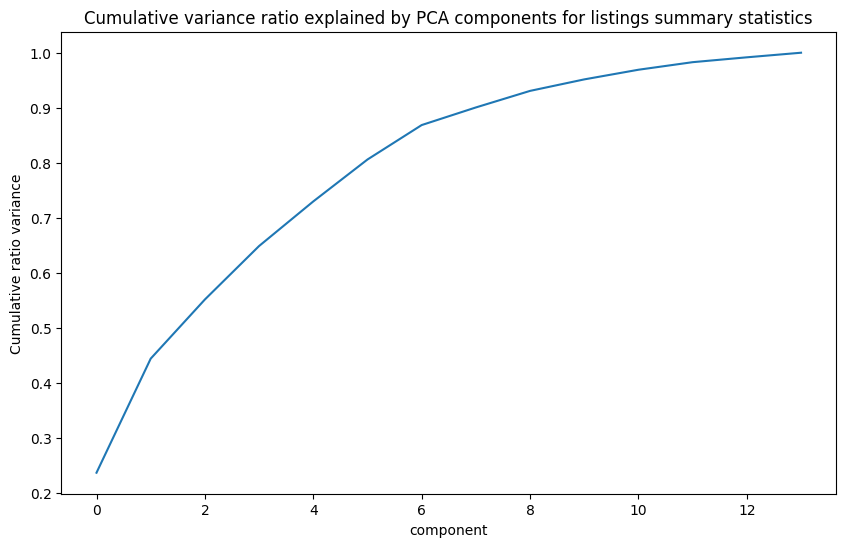

In [48]:
plt.subplots(figsize=(10, 6))
plt.plot(jc_pca.explained_variance_ratio_.cumsum())
plt.xlabel('component')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components for listings summary statistics');

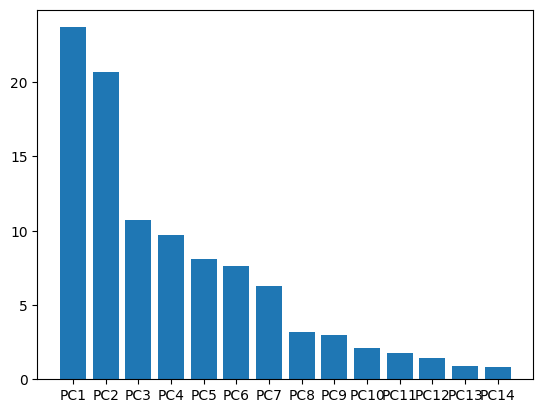

In [49]:
per_var = np.round(jc_pca.explained_variance_ratio_*100, decimals = 1)
labels = ['PC'+str(x) for x in range(1,len(per_var)+1)]

plt.bar(x = range(1,len(per_var)+1), height = per_var, tick_label = labels)
plt.show()

In [50]:
pca_data = jc_pca.transform(jc_features_scaled)
pca_df = pd.DataFrame(pca_data, columns = labels)

In [51]:
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
0,1.015950,1.196124,-0.278692,0.636628,-0.240067,-1.008649,-1.853576,0.763869,-1.443304,-0.422181,0.112247,-0.907170,-0.159925,-0.194045
1,0.676469,0.968651,-1.373188,0.984589,0.744416,-0.208315,0.418825,-0.421611,-0.497755,-0.697188,-0.176884,-1.049501,0.273752,0.469326
2,-1.666784,-0.599800,0.480137,1.277157,0.618055,-0.411170,-1.124616,-0.915483,-0.255299,0.026864,-0.207002,0.169564,-0.093034,0.470535
3,-1.491647,-0.763176,0.410248,-0.914791,-1.661045,-1.771294,1.925418,0.163155,0.042097,0.101546,0.246286,-0.105710,0.057064,-0.038695
4,1.789636,1.120707,-0.628684,1.153334,1.023040,0.013361,0.392182,-1.067013,-0.099149,-0.452922,-0.604175,-0.705183,-0.158454,-0.066873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526,-0.259633,-0.952256,0.078063,-1.542918,-0.267953,0.874455,0.198075,-0.030162,1.625253,-0.282447,-0.729296,0.367522,-0.032168,-0.314719
1527,-1.019838,0.758896,-1.082990,-0.034557,-0.536440,0.464754,0.277615,0.487998,0.214723,-0.032026,0.134777,-0.299168,0.085277,-0.285272
1528,-0.012946,0.146500,-0.631708,-0.629262,-0.520495,0.568270,0.195823,0.226806,-0.447783,0.468055,0.198822,-0.474650,1.794205,-0.109939
1529,-0.782902,0.865257,1.604063,-3.317122,-0.265284,-0.852262,2.552195,0.083931,-0.447262,0.234973,0.414644,-0.359303,0.054646,-0.441283


In [52]:
for i in range(0,6):
    pca_features = pd.DataFrame({labels[i]: jc_pca.components_[i],
                                 'Variable Names':list(scaled_cols)})
    print(pca_features)

         PC1             Variable Names
0  -0.197100          host_is_superhost
1   0.036783     host_identity_verified
2   0.017159                   latitude
3  -0.151199                  longitude
4   0.148914               accommodates
5   0.154337                   bedrooms
6   0.156296                       beds
7  -0.002646                      price
8  -0.069378          number_of_reviews
9  -0.455634       review_scores_rating
10 -0.462845  review_scores_cleanliness
11 -0.446775     review_scores_location
12 -0.487316        review_scores_value
13 -0.049860          reviews_per_month
         PC2             Variable Names
0   0.029443          host_is_superhost
1  -0.053713     host_identity_verified
2   0.043611                   latitude
3  -0.069181                  longitude
4   0.544521               accommodates
5   0.524161                   bedrooms
6   0.553672                       beds
7   0.180901                      price
8   0.064264          number_of_reviews


/var/folders/gj/nggxycj50vv7zds_fh4gtgjh0000gn/T/ipykernel_78161/1807748964.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(jc_features.corr().round(2), annot = True);


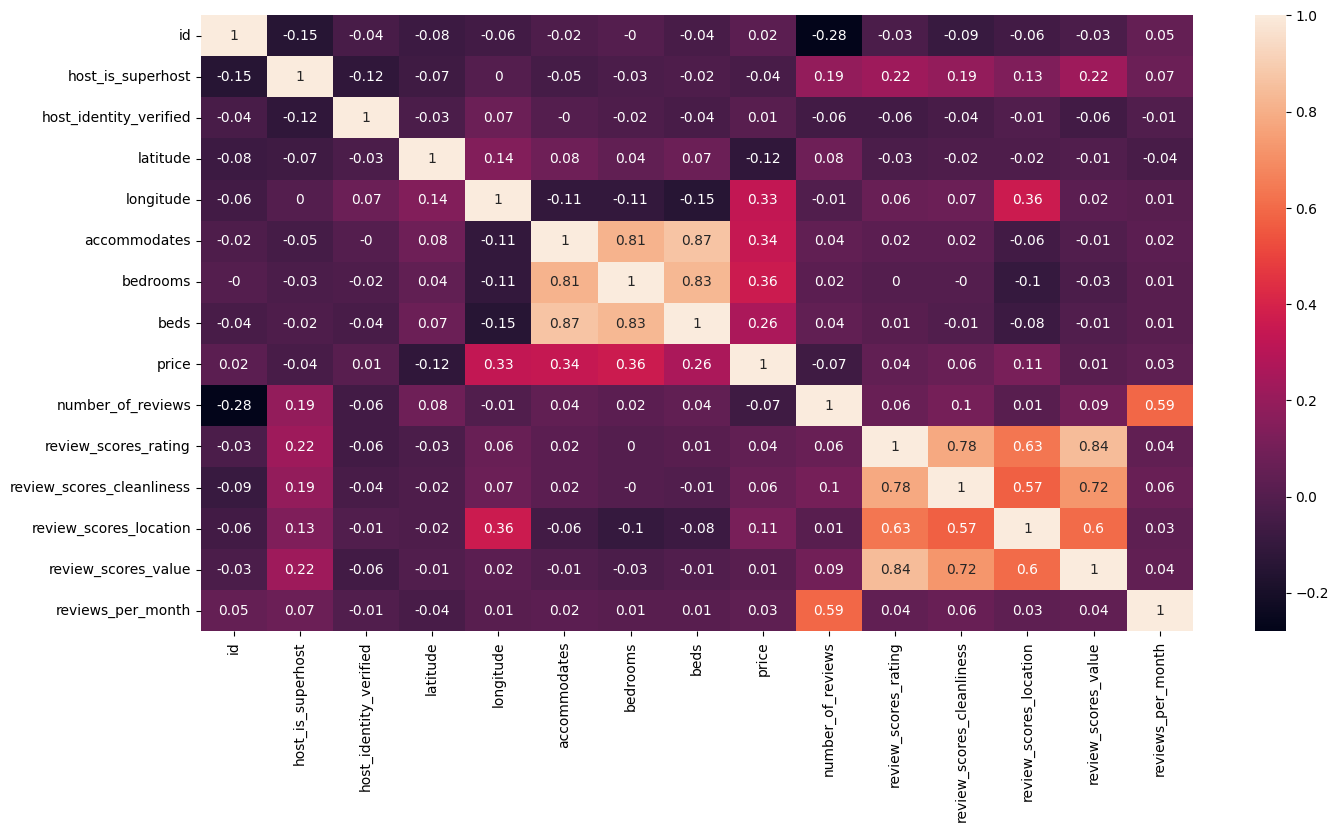

In [53]:
plt.figure(figsize=(16, 8))
sns.heatmap(jc_features.corr().round(2), annot = True);

In [54]:
nyc_features = nyc_listings[cols]

In [55]:
nyc_features['host_is_superhost'] = nyc_features['host_is_superhost'].map({'t':1,'f':0})
nyc_features['host_identity_verified'] = nyc_features['host_identity_verified'].map({'t':1,'f':0})

/var/folders/gj/nggxycj50vv7zds_fh4gtgjh0000gn/T/ipykernel_78161/454348638.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_features['host_is_superhost'] = nyc_features['host_is_superhost'].map({'t':1,'f':0})
/var/folders/gj/nggxycj50vv7zds_fh4gtgjh0000gn/T/ipykernel_78161/454348638.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_features['host_identity_verified'] = nyc_features['host_identity_verified'].map({'t':1,'f':0})


In [56]:
nyc_features.host_since = pd.to_datetime(nyc_features.host_since)

/var/folders/gj/nggxycj50vv7zds_fh4gtgjh0000gn/T/ipykernel_78161/345097157.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_features.host_since = pd.to_datetime(nyc_features.host_since)


/var/folders/gj/nggxycj50vv7zds_fh4gtgjh0000gn/T/ipykernel_78161/3909924102.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(nyc_features.corr().round(2), annot = True);


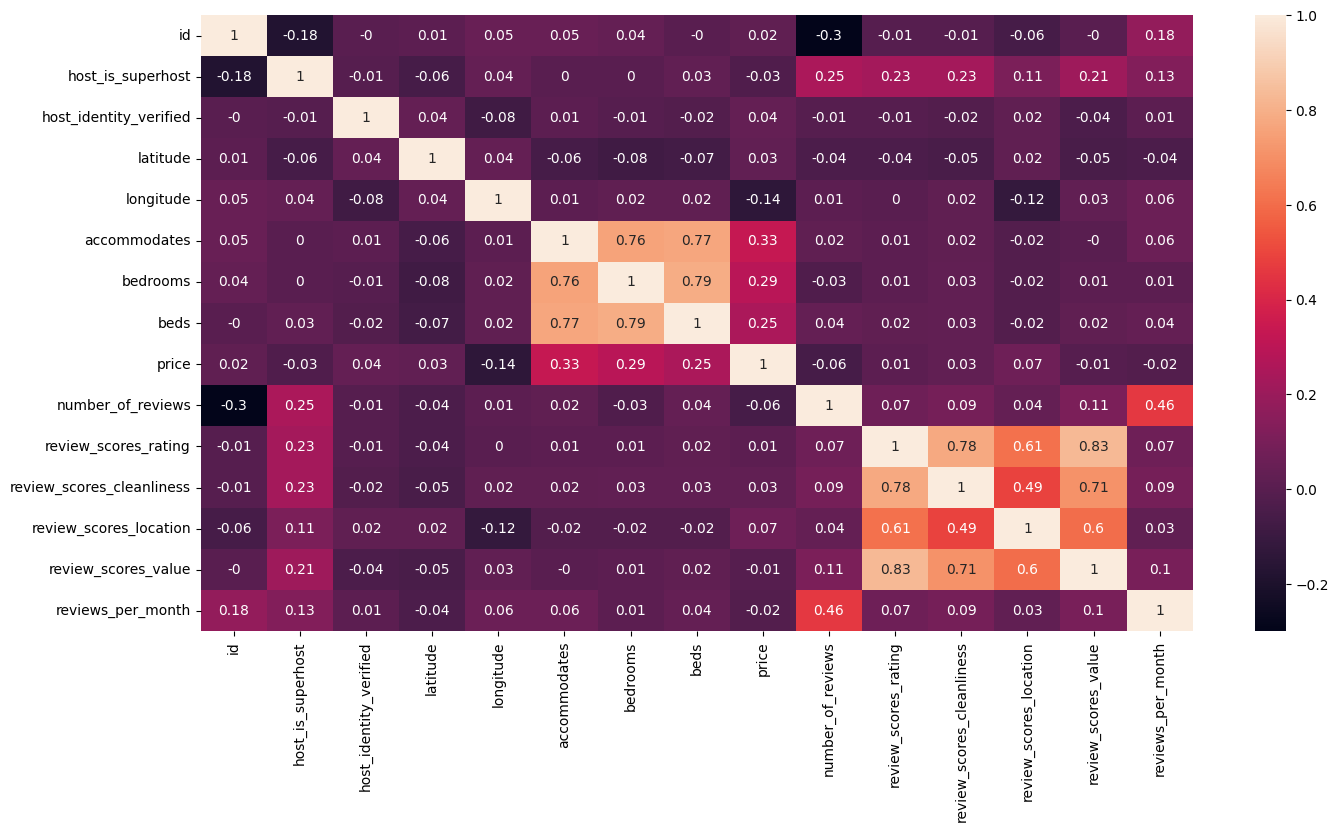

In [57]:
plt.figure(figsize=(16, 8))
sns.heatmap(nyc_features.corr().round(2), annot = True);

In [58]:
rio_features = rio_listings[cols]

In [59]:
rio_features['host_is_superhost'] = rio_features['host_is_superhost'].map({'t':1,'f':0})
rio_features['host_identity_verified'] = rio_features['host_identity_verified'].map({'t':1,'f':0})

/var/folders/gj/nggxycj50vv7zds_fh4gtgjh0000gn/T/ipykernel_78161/552760642.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rio_features['host_is_superhost'] = rio_features['host_is_superhost'].map({'t':1,'f':0})
/var/folders/gj/nggxycj50vv7zds_fh4gtgjh0000gn/T/ipykernel_78161/552760642.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rio_features['host_identity_verified'] = rio_features['host_identity_verified'].map({'t':1,'f':0})


In [60]:
rio_features.host_since = pd.to_datetime(rio_features.host_since)

/var/folders/gj/nggxycj50vv7zds_fh4gtgjh0000gn/T/ipykernel_78161/294954377.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rio_features.host_since = pd.to_datetime(rio_features.host_since)


/var/folders/gj/nggxycj50vv7zds_fh4gtgjh0000gn/T/ipykernel_78161/2790036435.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(rio_features.corr().round(2), annot= True);


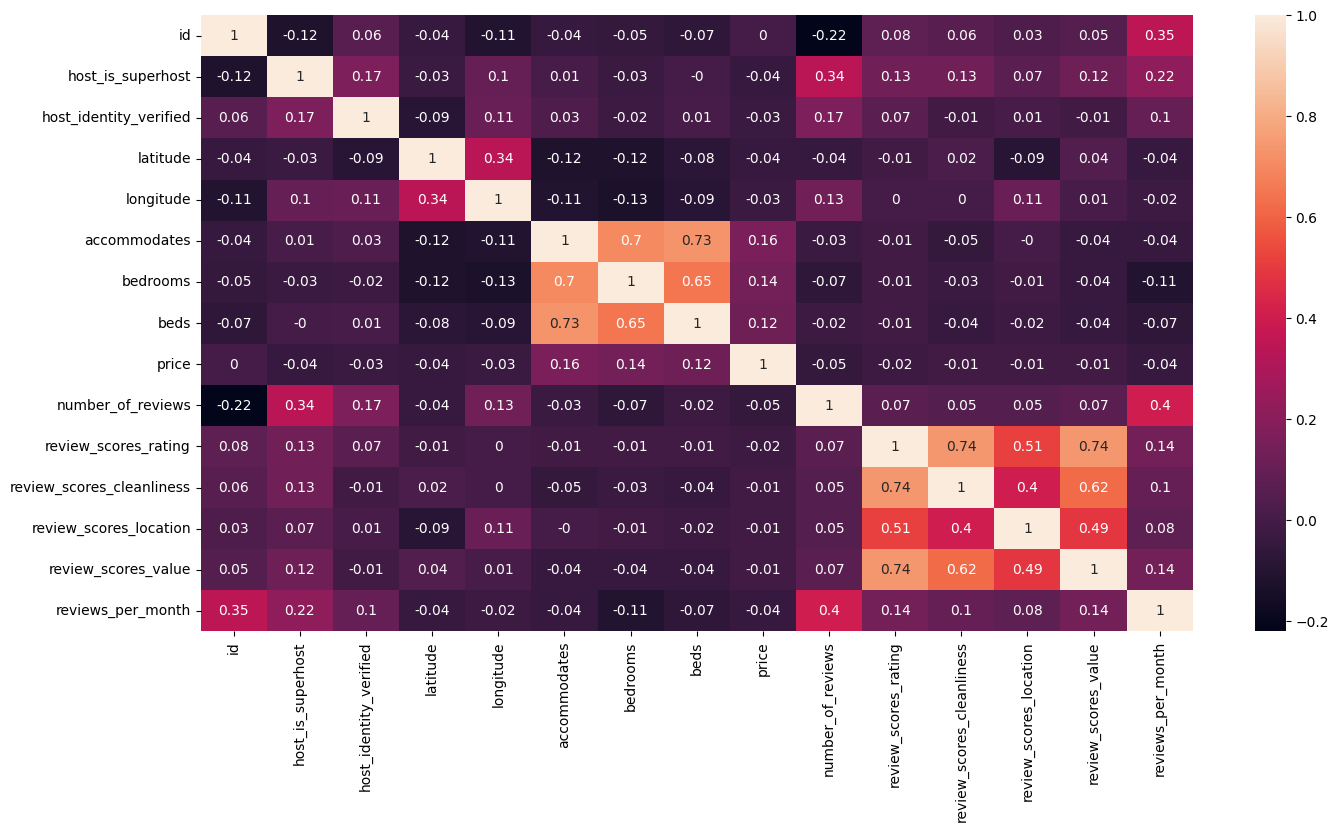

In [61]:
plt.figure(figsize=(16, 8))
sns.heatmap(rio_features.corr().round(2), annot= True);

The dimention reduction analysis through PCA was not conclusive, because each pricipal component explanation power were retalive small. It takes 6 PCs to explain around 90% of the variation.

The correlation heat map was able to help in feature engeneering. The price was positively correlated with accommodates (number of people the list is able to accommodates), (number of ) bedrroms and (number of) beds. reviews on sores rating, cleaningess, location and value was positive for most cities. Jersey city and Newyork identity verifies of host was also positive, but this might be cause by the number of rooms rental instead of the hole apartment.

Number of review or review per month doesn't seem to have a positive corrlation with price.

While accommodates, bedrooms and beds are all positive correlated with price they are highly correlated among themself therefore we will use only accommodates feature for modeling to avoid cross-correlation among the explanatory variable.

latitude and longitude correlation was mixed but we will use neghboorhod information for out modeling.

We chose the following features for our modeling

In [69]:
features = ['neighbourhood_cleansed', 'room_type','latitude','longitude', 'bedrooms', 'beds',
            'accommodates', 'review_scores_rating', 'review_scores_cleanliness',
            'review_scores_location', 'review_scores_value']

# Preprocesses Data

Selecting the features

In [71]:
# Jersey City data

jc_features = jc_listings[features]
jc_target = jc_listings.price

jc_features.info() , jc_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2029 entries, 0 to 2565
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   neighbourhood_cleansed     2029 non-null   object 
 1   room_type                  2029 non-null   object 
 2   latitude                   2029 non-null   float64
 3   longitude                  2029 non-null   float64
 4   bedrooms                   1858 non-null   float64
 5   beds                       1974 non-null   float64
 6   accommodates               2029 non-null   int64  
 7   review_scores_rating       1709 non-null   float64
 8   review_scores_cleanliness  1707 non-null   float64
 9   review_scores_location     1707 non-null   float64
 10  review_scores_value        1707 non-null   float64
dtypes: float64(8), int64(1), object(2)
memory usage: 190.2+ KB
<class 'pandas.core.series.Series'>
Int64Index: 2029 entries, 0 to 2565
Series name: price
Non-Null C

(None, None)

In [72]:
# Rio data

rio_features = rio_listings[features]
rio_target = rio_listings.price

rio_features.info(), rio_target.info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23278 entries, 0 to 26365
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   neighbourhood_cleansed     23278 non-null  object 
 1   room_type                  23278 non-null  object 
 2   latitude                   23278 non-null  float64
 3   longitude                  23278 non-null  float64
 4   bedrooms                   22148 non-null  float64
 5   beds                       23098 non-null  float64
 6   accommodates               23278 non-null  int64  
 7   review_scores_rating       17154 non-null  float64
 8   review_scores_cleanliness  16979 non-null  float64
 9   review_scores_location     16979 non-null  float64
 10  review_scores_value        16979 non-null  float64
dtypes: float64(8), int64(1), object(2)
memory usage: 2.1+ MB


(None,
 <bound method Series.info of 0        3500.0
 1        5000.0
 2         681.0
 3        8999.0
 4         500.0
           ...  
 26361     115.0
 26362     149.0
 26363      60.0
 26364     320.0
 26365     657.0
 Name: price, Length: 23278, dtype: float64>)

In [73]:
# New York City data

nyc_features = nyc_listings[features]
nyc_target = nyc_listings.price

nyc_features.info(), nyc_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22619 entries, 0 to 39879
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   neighbourhood_cleansed     22619 non-null  object 
 1   room_type                  22619 non-null  object 
 2   latitude                   22619 non-null  float64
 3   longitude                  22619 non-null  float64
 4   bedrooms                   20570 non-null  float64
 5   beds                       22157 non-null  float64
 6   accommodates               22619 non-null  int64  
 7   review_scores_rating       19108 non-null  float64
 8   review_scores_cleanliness  19083 non-null  float64
 9   review_scores_location     19083 non-null  float64
 10  review_scores_value        19083 non-null  float64
dtypes: float64(8), int64(1), object(2)
memory usage: 2.1+ MB
<class 'pandas.core.series.Series'>
Int64Index: 22619 entries, 0 to 39879
Series name: price
Non-Null

(None, None)

Processing pipeline for numeric and categorical data

In [74]:
# Data Processing Pipeline

num_atributes = ['latitude','longitude', 'bedrooms', 'beds',
            'accommodates', 'review_scores_rating', 'review_scores_cleanliness',
            'review_scores_location', 'review_scores_value']

cat_atributes = ['neighbourhood_cleansed', 'room_type']

num_steps = [("imputer", SimpleImputer(missing_values=np.nan, strategy="median")), 
            ("scaler", StandardScaler())]

cat_steps = [("one_hot", OneHotEncoder(handle_unknown= 'ignore'))]

# data pipeline

num_pipeline = Pipeline(num_steps)
cat_pipeline = Pipeline(cat_steps)

preprocessor = ColumnTransformer([
                ("num", num_pipeline, num_atributes),
                ("cat", cat_pipeline, cat_atributes)])


# Jersey City

## Train test split and Base Models fit

In [75]:
# train test split
# JC

X = jc_features
y = np.log(jc_target)

jc_X_train,jc_X_test,jc_y_train,jc_y_test = train_test_split(X,y, test_size=0.3, random_state=27)

In [76]:
# Models fit

pipe_1 = Pipeline(steps = [("preprocess",preprocessor),("model", Lasso(alpha=.1))])
pipe_2 = Pipeline(steps = [("preprocess",preprocessor),("model", LinearRegression())])
pipe_3 = Pipeline(steps = [("preprocess",preprocessor),("model", RandomForestRegressor())])
pipe_4 = Pipeline(steps = [("preprocess",preprocessor),("model", xgb.XGBRegressor(eval_metric = 'rmse'))])

jc_Lasso = pipe_1.fit(jc_X_train, jc_y_train)
jc_LR = pipe_2.fit(jc_X_train, jc_y_train)
jc_RFR = pipe_3.fit(jc_X_train, jc_y_train)
jc_XGB = pipe_4.fit(jc_X_train, jc_y_train)



# Models Evaluation

In [77]:
# Model valuation

model_score = [jc_Lasso.score(jc_X_test, jc_y_test), 
               jc_LR.score(jc_X_test, jc_y_test), 
               jc_RFR.score(jc_X_test, jc_y_test),
               jc_XGB.score(jc_X_test, jc_y_test)]

predictions = (pipe_1.predict(jc_X_test), pipe_2.predict(jc_X_test), pipe_3.predict(jc_X_test),  pipe_4.predict(jc_X_test))

jc_rmse = []
for pred in predictions:
    jc_rmse.append(np.sqrt(mean_squared_error(np.exp(jc_y_test),np.exp(pred))))


In [78]:
print(model_score, '\n',jc_rmse)

[0.5310159122066962, 0.6178642654956971, 0.7405207482863085, 0.7149967942580913] 
 [490.2835672567867, 468.86694332310805, 453.3932688021678, 444.25175362849086]


Best models are Random Forest Regressor and XGB; We will optimize these two models

# Grid search and cross validation

In [79]:
# XGB GridSearchCV
xgb_params = {'model__n_estimators': range(50,250,25),
              'model__max_depth' : range(2,10,1),
              "model__min_child_weight":range(1, 5,1),
              'model__learning_rate': [0.1, 0.01]}

xgb_grid = GridSearchCV(estimator = pipe_4,
                        param_grid = xgb_params,
                        scoring = 'neg_mean_squared_error',
                        n_jobs = 10,
                        cv = 5)

xgb_grid.fit(jc_X_train, jc_y_train)

jc_xgb_grid = xgb_grid.best_estimator_

In [80]:
print(xgb_grid.best_params_, '\n', xgb_grid.best_score_)

{'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__min_child_weight': 4, 'model__n_estimators': 100} 
 -0.16406199130564872


In [81]:
# Random Forest GridSearchCV

rfr_params = {'model__n_estimators': range(50,250,25),
              'model__max_features': ['sqrt', 'log2', None],
              'model__max_depth' : range(2,10,1),
              'model__min_samples_split' : range(2,10,1)}

rfr_grid = GridSearchCV(estimator = pipe_3,
                        param_grid = rfr_params,
                        scoring = 'neg_mean_squared_error',
                        n_jobs = 10,
                        cv = 5)

rfr_grid.fit(jc_X_train, jc_y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['latitude',
                                                                          'longitude',
                                                                          'bedrooms',
                                                                          'beds',
                                                                          'accommodates',
                                                                          'review_scores_rating',
                                                                          'review_scores_cleanliness',
                                                                          'review_scores_location',
                                                                          'review_scores_value']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('one_hot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['neighbourhood_cleansed',
                                                                          'room_type'])])),
                                       ('model', RandomForestRegressor())]),
             n_jobs=10,
             param_grid={'model__max_depth': range(2, 10),
                         'model__max_features': ['sqrt', 'log2', None],
                         'model__min_samples_split': range(2, 10),
                         'model__n_estimators': range(50, 250, 25)},
             scoring='neg_mean_squared_error')

In [82]:
print(rfr_grid.best_params_, '\n', rfr_grid.best_score_)

{'model__max_depth': 9, 'model__max_features': None, 'model__min_samples_split': 2, 'model__n_estimators': 225} 
 -0.17006945760887646


# Rio

## Train test split and Base Models fit

In [83]:
# train test split
# Rio

X = rio_features
y = np.log(rio_target)

rio_X_train,rio_X_test,rio_y_train,rio_y_test = train_test_split(X,y, test_size=0.3, random_state=27)

In [84]:
# Model fit

rio_Lasso = pipe_1.fit(rio_X_train, rio_y_train)
rio_LR = pipe_2.fit(rio_X_train, rio_y_train)
rio_RFR = pipe_3.fit(rio_X_train, rio_y_train)
rio_XGB = pipe_4.fit(rio_X_train, rio_y_train)

## Madels Evaluation

In [85]:
# Model valuation

model_score = [rio_Lasso.score(rio_X_test, rio_y_test), 
               rio_LR.score(rio_X_test, rio_y_test), 
               rio_RFR.score(rio_X_test, rio_y_test),
               rio_XGB.score(rio_X_test, rio_y_test)]

predictions = (pipe_1.predict(rio_X_test), pipe_2.predict(rio_X_test), pipe_3.predict(rio_X_test),  pipe_4.predict(rio_X_test))

rio_rmse = []
for pred in predictions:
    rio_rmse.append(np.sqrt(mean_squared_error(np.exp(rio_y_test),np.exp(pred))))

In [86]:
print(model_score, '\n',rio_rmse)

[0.3221635733003424, 0.4019426449710226, 0.5005523754057496, 0.5328262921973235] 
 [3137.869023632235, 3672.349365228089, 2390.632818322533, 2587.1553659561914]


Best models are Random Forest Regressor and XGB; We will optimize these two models

## Grid search and cross validation

In [87]:
# XGB GridSearchCV
xgb_params = {'model__n_estimators': range(50,250,25),
              'model__max_depth' : range(2,10,1),
              "model__min_child_weight":range(1, 5,1),
              'model__learning_rate': [0.1, 0.01]}

xgb_grid = GridSearchCV(estimator = pipe_4,
                        param_grid = xgb_params,
                        scoring = 'neg_mean_squared_error',
                        n_jobs = 10,
                        cv = 5)

xgb_grid.fit(rio_X_train, rio_y_train)

rio_xgb_grid = xgb_grid.best_estimator_

In [88]:
print(xgb_grid.best_params_, '\n', xgb_grid.best_score_)

{'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__min_child_weight': 4, 'model__n_estimators': 150} 
 -0.4285638909399737


In [89]:
# Random Forest GridSearchCV

rfr_params = {'model__n_estimators': range(50,250,25),
              'model__max_features': ['sqrt', 'log2', None],
              'model__max_depth' : range(2,10,1),
              'model__min_samples_split' : range(2,10,1)}

rfr_grid = GridSearchCV(estimator = pipe_3,
                        param_grid = rfr_params,
                        scoring = 'neg_mean_squared_error',
                        n_jobs = 10,
                        cv = 5)

rfr_grid.fit(rio_X_train, rio_y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['latitude',
                                                                          'longitude',
                                                                          'bedrooms',
                                                                          'beds',
                                                                          'accommodates',
                                                                          'review_scores_rating',
                                                                          'review_scores_cleanliness',
                                                                          'review_scores_location',
                                                                          'review_scores_value']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('one_hot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['neighbourhood_cleansed',
                                                                          'room_type'])])),
                                       ('model', RandomForestRegressor())]),
             n_jobs=10,
             param_grid={'model__max_depth': range(2, 10),
                         'model__max_features': ['sqrt', 'log2', None],
                         'model__min_samples_split': range(2, 10),
                         'model__n_estimators': range(50, 250, 25)},
             scoring='neg_mean_squared_error')

In [90]:
print(rfr_grid.best_params_, '\n', rfr_grid.best_score_)

{'model__max_depth': 9, 'model__max_features': None, 'model__min_samples_split': 2, 'model__n_estimators': 225} 
 -0.4518193281275161


# New York City

## Train test split and Base Models fit

In [91]:
# train test split
# NYC

X = nyc_features
y = np.log(nyc_target)

nyc_X_train,nyc_X_test,nyc_y_train,nyc_y_test = train_test_split(X,y, test_size=0.3, random_state=11)

In [92]:
# Model fit

nyc_Lasso = pipe_1.fit(nyc_X_train, nyc_y_train)
nyc_LR = pipe_2.fit(nyc_X_train, nyc_y_train)
nyc_RFR = pipe_3.fit(nyc_X_train, nyc_y_train)
nyc_XGB = pipe_4.fit(nyc_X_train, nyc_y_train)

## Models Evaluation

In [93]:
# Model valuation

model_score = [nyc_Lasso.score(nyc_X_test, nyc_y_test), 
               nyc_LR.score(nyc_X_test, nyc_y_test), 
               nyc_RFR.score(nyc_X_test, nyc_y_test),
               nyc_XGB.score(nyc_X_test, nyc_y_test)]

predictions = (pipe_1.predict(nyc_X_test), pipe_2.predict(nyc_X_test), pipe_3.predict(nyc_X_test),  pipe_4.predict(nyc_X_test))

nyc_rmse = []
for pred in predictions:
    nyc_rmse.append(np.sqrt(mean_squared_error(np.exp(nyc_y_test),np.exp(pred))))

In [94]:
print(model_score, '\n',nyc_rmse)

[0.3672469498189811, 0.6079458528131347, 0.67790553230118, 0.6737415335172543] 
 [369.41828822053384, 353.72387007637934, 338.2567025633688, 344.32069219037436]


## Grid search and cross validation

In [95]:
# Grid Search and cross validation:
# XGB GridSearchCV
xgb_params = {'model__n_estimators': range(50,250,25),
              'model__max_depth' : range(2,10,1),
              "model__min_child_weight":range(1, 5,1),
              'model__learning_rate': [0.1, 0.01]}

xgb_grid = GridSearchCV(estimator = pipe_4,
                        param_grid = xgb_params,
                        scoring = 'neg_mean_squared_error',
                        n_jobs = 10,
                        cv = 5)

xgb_grid.fit(nyc_X_train, nyc_y_train)

nyc_xgb_grid = xgb_grid.best_estimator_

In [96]:
print(xgb_grid.best_params_, '\n', xgb_grid.best_score_)

{'model__learning_rate': 0.1, 'model__max_depth': 9, 'model__min_child_weight': 4, 'model__n_estimators': 200} 
 -0.1769300120437416


In [97]:
# Random Forest GridSearchCV

rfr_params = {'model__n_estimators': range(50,250,25),
              'model__max_features': ['sqrt', 'log2', None],
              'model__max_depth' : range(2,10,1),
              'model__min_samples_split' : range(2,10,1)}

rfr_grid = GridSearchCV(estimator = pipe_3,
                        param_grid = rfr_params,
                        scoring = 'neg_mean_squared_error',
                        n_jobs = 10,
                        cv = 5)

rfr_grid.fit(nyc_X_train, nyc_y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['latitude',
                                                                          'longitude',
                                                                          'bedrooms',
                                                                          'beds',
                                                                          'accommodates',
                                                                          'review_scores_rating',
                                                                          'review_scores_cleanliness',
                                                                          'review_scores_location',
                                                                          'review_scores_value']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('one_hot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['neighbourhood_cleansed',
                                                                          'room_type'])])),
                                       ('model', RandomForestRegressor())]),
             n_jobs=10,
             param_grid={'model__max_depth': range(2, 10),
                         'model__max_features': ['sqrt', 'log2', None],
                         'model__min_samples_split': range(2, 10),
                         'model__n_estimators': range(50, 250, 25)},
             scoring='neg_mean_squared_error')

In [98]:
print(rfr_grid.best_params_, '\n', rfr_grid.best_score_)

{'model__max_depth': 9, 'model__max_features': None, 'model__min_samples_split': 3, 'model__n_estimators': 175} 
 -0.19497319072462113


XGBoosting Regression consistently out perfrom Random Forest Regression for the three case studies. Next we will build the best model for each city, measure its performance and save the model.

## Final Model Selection¶

## Model Performance

In [99]:
model_score = [round(jc_xgb_grid.score(jc_X_test, jc_y_test)*100,2), 
               round(rio_xgb_grid.score(rio_X_test, rio_y_test)*100,2), 
               round(nyc_xgb_grid.score(nyc_X_test, nyc_y_test)*100,2)]

predictions = (jc_xgb_grid.predict(jc_X_test), 
               rio_xgb_grid.predict(rio_X_test),
               nyc_xgb_grid.predict(nyc_X_test))
test_data = [jc_y_test, rio_y_test, nyc_y_test]
               
models_rmse = []
for pred, data in zip(predictions, test_data):
    models_rmse.append(np.sqrt(mean_squared_error(np.exp(data),np.exp(pred))))
    
data = {'R\u00b2': model_score, 'rmse': models_rmse}
cities = ['JC', 'Rio', 'NYC']

performance = pd.DataFrame(data,index = cities)

print(performance)

        R²         rmse
JC   73.25   451.357770
Rio  55.14  2608.690148
NYC  69.03   338.054077


Grid Search hyperparameters optimization improved all XBoost models coeficient of determination. Jersey City root mean squared error (rmse) was marginaly improved while Rio and New York City were marginally worse. These results increase our confidense that the models aren't overfiting the current data. Note Rio rmse is larger than the rest because it is quoted in Brazilian Reais.

## Save best model object 

In [100]:
import datetime
# JC

jc_best_model = jc_xgb_grid
jc_best_model.version = '1.0'
jc_best_model.pandas_version = pd.__version__
jc_best_model.numpy_version = np.__version__
jc_best_model.xgb_version = xgb.__version__
jc_best_model.X_columns = [col for col in jc_X_train.columns]
jc_best_model.build_datetime = datetime.datetime.now()

# Rio

rio_best_model = rio_xgb_grid
rio_best_model.version = '1.0'
rio_best_model.pandas_version = pd.__version__
rio_best_model.numpy_version = np.__version__
rio_best_model.xgb_version = xgb.__version__
rio_best_model.X_columns = [col for col in jc_X_train.columns]
rio_best_model.build_datetime = datetime.datetime.now()

# NYC

nyc_best_model = jc_xgb_grid
nyc_best_model.version = '1.0'
nyc_best_model.pandas_version = pd.__version__
nyc_best_model.numpy_version = np.__version__
nyc_best_model.xgb_version = xgb.__version__
nyc_best_model.X_columns = [col for col in jc_X_train.columns]
nyc_best_model.build_datetime = datetime.datetime.now()

In [101]:
# save the model
import joblib
modelpath = '../models'

joblib.dump(jc_best_model, modelpath+'jc_pricing_model.pkl')
joblib.dump(rio_best_model, modelpath+'rio_pricing_model.pkl')
joblib.dump(nyc_best_model, modelpath+'nyc_pricing_model.pkl')

['../modelsnyc_pricing_model.pkl']